In [1]:
## Common import cell!

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.svm
import sqlite3

font = {'size'   : 18}

plt.matplotlib.rc('font', **font)

# Machine Learning: Classification

# 1. Data preparation

From preliminary data analysis, I have identified several factors which may be correlated with wildfire risk, and therefore, may be useful in characterizing the cause of a given wildfire. These features are: discovery day, fire year, fire size, latitude, and longitude. We start with a simple binary of classifying whether a given fire was caused by lightning or not (statistical cause code 1.0). 

In [2]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
cause_df = pd.read_sql('SELECT STAT_CAUSE_CODE, STAT_CAUSE_DESCR from fires',conn)
cause_df[1:20]

,STAT_CAUSE_CODE,STAT_CAUSE_DESCR
1,1.0,Lightning
2,5.0,Debris Burning
3,1.0,Lightning
4,1.0,Lightning
5,1.0,Lightning
6,1.0,Lightning
7,5.0,Debris Burning
8,5.0,Debris Burning
9,1.0,Lightning
10,1.0,Lightning


In [3]:
rel_df = pd.read_sql('SELECT FIRE_YEAR, DISCOVERY_DOY, DISCOVERY_TIME, STAT_CAUSE_CODE, STAT_CAUSE_DESCR, FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE FROM fires',conn)



In [4]:
rel_df['cause_lightning'] = rel_df.STAT_CAUSE_CODE.isin([1.0])
rel_df

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
0,2005,33,1300,9.0,Miscellaneous,0.10,A,40.036944,-121.005833,False
1,2004,133,0845,1.0,Lightning,0.25,A,38.933056,-120.404444,True
2,2004,152,1921,5.0,Debris Burning,0.10,A,38.984167,-120.735556,False
3,2004,180,1600,1.0,Lightning,0.10,A,38.559167,-119.913333,True
4,2004,180,1600,1.0,Lightning,0.10,A,38.559167,-119.933056,True
...,...,...,...,...,...,...,...,...,...,...
1880460,2015,269,1726,13.0,Missing/Undefined,0.01,A,40.481637,-122.389375,False
1880461,2015,278,0126,9.0,Miscellaneous,0.20,A,37.617619,-120.938570,False
1880462,2015,122,2052,13.0,Missing/Undefined,0.10,A,37.617619,-120.938570,False
1880463,2015,287,2309,13.0,Missing/Undefined,2.00,B,37.672235,-120.898356,False


Before we can apply our machine learning algorithms on this dataset, we need to rescale each of the numerical feature columns so that the minimum value in each column is 0, and the maximum value is 1. We should also remove the rows where the cause is classified as Missing/Undefined or as Miscellaneous as these categories are not well defined and may throw off the model.

In [5]:
features = ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']
rel_df.drop(rel_df.index[rel_df['STAT_CAUSE_DESCR'] == 'Missing/Undefined'], inplace=True)
rel_df.drop(rel_df.index[rel_df['STAT_CAUSE_DESCR'] == 'Miscellaneous'], inplace=True)

for col_name in ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']:
    cmin = rel_df[col_name].min()
    cmax = rel_df[col_name].max()
    
    rel_df[col_name] = (rel_df[col_name] - cmin) / (cmax - cmin)
    
rel_df

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
1,0.521739,0.361644,0845,1.0,Lightning,4.117507e-07,A,0.400646,0.514314,True
2,0.521739,0.413699,1921,5.0,Debris Burning,1.646113e-07,A,0.401622,0.511398,False
3,0.521739,0.490411,1600,1.0,Lightning,1.646113e-07,A,0.393509,0.518640,True
4,0.521739,0.490411,1600,1.0,Lightning,1.646113e-07,A,0.393509,0.518466,True
5,0.521739,0.495890,1800,1.0,Lightning,1.646113e-07,A,0.394962,0.516964,True
...,...,...,...,...,...,...,...,...,...,...
1880451,1.000000,0.427397,1208,2.0,Equipment Use,1.647447e-06,B,0.395132,0.510270,False
1880452,1.000000,0.282192,0827,5.0,Debris Burning,1.975632e-07,A,0.309592,0.529384,False
1880453,1.000000,0.512329,0723,8.0,Children,1.975632e-07,A,0.311789,0.530020,False
1880457,1.000000,0.745205,2357,7.0,Arson,1.647447e-06,B,0.432249,0.490842,False


In [6]:
import numpy.testing as npt

for col_name in ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']:
    npt.assert_allclose(rel_df[col_name].min(), 0)
    npt.assert_allclose(rel_df[col_name].max(), 1)

Next, we split our data into training and testing datasets. This can be done using Sklearn but I will implement it manually first.

In [7]:
import random
nInds = rel_df.shape[0]
inds = range(nInds)
testInds = random.sample(inds,round((nInds-1)/2))
mask=np.full(len(inds),True,dtype=bool)
mask[testInds]=False
rel_train = rel_df.loc[~mask,:]
rel_test = rel_df.loc[mask,:]

# 2. Unsupervised learning

First we use the K-means clustering algorithm to do some unsupervised learning. 

In [45]:
kmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=0).fit(rel_train[features])

print(kmeans.labels_)

[0 0 0 ... 0 0 0]


In [46]:
rel_train.loc[np.asarray(kmeans.labels_, bool),:]


,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
6849,0.434783,0.528767,1943,1.0,Lightning,1.646113e-07,A,0.372177,0.525979,True
41841,0.478261,0.273973,1300,8.0,Children,1.646113e-07,A,0.561266,0.744970,False
41843,0.434783,0.630137,1400,1.0,Lightning,1.646113e-07,A,0.335250,0.593000,True
41844,0.434783,0.630137,1529,1.0,Lightning,1.646113e-07,A,0.333299,0.593093,True
41845,0.434783,0.635616,1210,1.0,Lightning,4.942639e-06,B,0.331188,0.593507,True
...,...,...,...,...,...,...,...,...,...,...
1453958,0.304348,0.997260,1410,5.0,Debris Burning,1.977100e-05,C,0.357437,0.762737,False
1721820,0.478261,0.465753,1600,1.0,Lightning,8.732257e-03,G,0.289648,0.625146,True
1860059,0.000000,0.389041,1030,4.0,Campfire,1.646113e-07,A,0.535708,0.500262,False
1860062,0.000000,0.410959,1730,4.0,Campfire,1.646113e-07,A,0.535676,0.500203,False


Text(0, 0.5, 'Latitude')

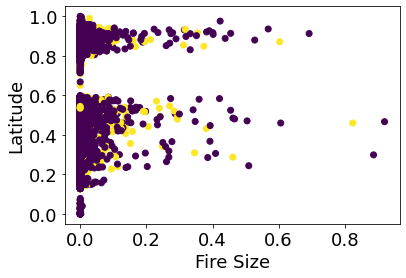

In [47]:
plt.scatter(rel_train['FIRE_SIZE'], rel_train['LATITUDE'], c=kmeans.labels_)
plt.xlabel('Fire Size')
plt.ylabel('Latitude')

In [48]:
pred_labels = kmeans.predict(rel_test[features].dropna())
print(pred_labels)

rel_test.loc[np.asarray(pred_labels, bool), :]

[0 0 0 ... 0 0 0]


,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
41840,0.391304,0.742466,1400,4.0,Campfire,1.647447e-06,B,0.574586,0.777537,False
41852,0.434783,0.657534,0800,1.0,Lightning,2.059346e-06,B,0.325324,0.590466,True
41853,0.434783,0.657534,0800,1.0,Lightning,1.646113e-07,A,0.332355,0.593110,True
41857,0.434783,0.657534,0830,1.0,Lightning,1.646113e-07,A,0.329385,0.592560,True
41864,0.434783,0.657534,0800,1.0,Lightning,4.117507e-07,A,0.327731,0.590446,True
...,...,...,...,...,...,...,...,...,...,...
1453960,0.304348,0.997260,1630,7.0,Arson,1.977113e-04,D,0.382872,0.775016,False
1721873,0.434783,0.547945,None,1.0,Lightning,4.242889e-02,G,0.880114,0.241521,True
1860060,0.000000,0.498630,1500,4.0,Campfire,1.646113e-07,A,0.535549,0.500262,False
1860061,0.000000,0.221918,1600,4.0,Campfire,1.646113e-07,A,0.535708,0.500248,False


Text(0, 0.5, 'Latitude')

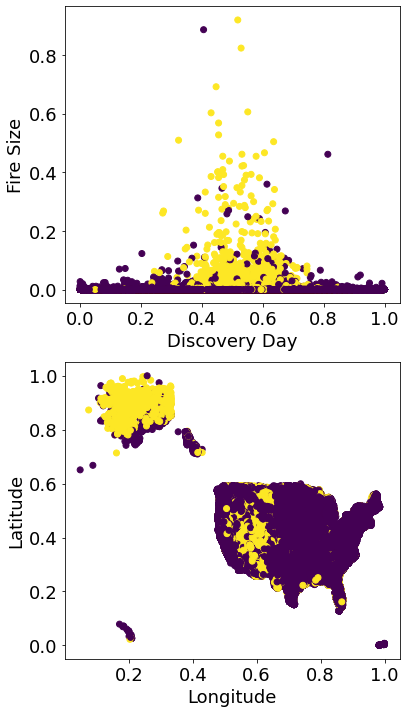

In [50]:
fig, axes = plt.subplots(2,1, figsize=(6,12))
axes[0].scatter(rel_train['DISCOVERY_DOY'], rel_train['FIRE_SIZE'], c=rel_train['cause_lightning'])
axes[0].set_xlabel('Discovery Day')
axes[0].set_ylabel('Fire Size')
axes[1].scatter(rel_train['LONGITUDE'], rel_train['LATITUDE'], c=rel_train['cause_lightning'])
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

Because we used our clustering algorithm on the longitude and latitude data, it seems our unsupervised algorithm has divided the data into two clusters: Alaska and the mainland US. That is likely why it does not do so well at predicting whether or not the cause of the fire was lightning. 

# 3. Supervised machine learning

## 3. a) Binary Classification Test

As in the tutorial, we will use the method of logistic regression. For this method, we model the probability distribution for a binary classifier as 
\\[
p(y_i = 1 | \mathbf{x}_i, \mathbf{w}) \equiv \sigma(\mathbf{x}_i^T \mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{x}_i^T \mathbf{w})} 
\\]

Here $\mathbf{x}_i$ is the __feature vector__ and $\mathbf{y}_i$ is the __label__ for the $i$-th data point.  The weights $\mathbf{w}$ define the model: a larger weight for a given component of $\mathbf{x}$ will give that feature more influence on the probability distribution.

The cost function is readily found as the log-likelihood of the whole dataset to be

\\[
C(\mathbf{w}) = -\log \prod_i P(y_i = 1)^{y_i} P(y_i = 0)^{1-y_i} \\
= -\sum_{i} \left[\mathbf{y}_i \log \sigma (\mathbf{x}_i^T \mathbf{w}) + (1-\mathbf{y}_i) \log (1 - \sigma(\mathbf{x}_i^T \mathbf{w}) ) \right].
\\]

In [52]:
def sigmoid(s):
    return 1 / (1 + np.exp(-s))

def cross_entropy(x, w, y):
    """
    Compute the cross entropy, a.k.a. the log likelihood
    for the logistic regression model..
    
    Inputs:
      - x: 2d array of feature vectors, with features as columns.
      - w: 1d array of feature weights, same length as a feature vector.
      - y: 1d array of data labels, should be binary (1 or 0)
      
    Return:
      - C(w): the cross entropy.
    """
    
    y = y.astype(int)
    xw = np.matmul(x,w)
    s = sigmoid(xw)
    Ci = np.multiply(y,np.log(s)) + np.multiply((1 - y),np.log(1-s))
    C = -sum(Ci)
    
        
    return C
    

In [55]:
x_test = np.array([[0,1],[1,1]])
y_test = np.array([0,1])
w_test = np.array([0.2,0.4])

npt.assert_allclose(cross_entropy(x_test, w_test, y_test), 1.35, atol=1e-2)

In [56]:
import scipy.optimize as opt

features = ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']


def CE_train(w):
    return cross_entropy(rel_train[features].values, w, rel_train['cause_lightning'].values)

res = opt.minimize(CE_train, [0,0,0,0,0])
w_opt = res.x
print(res)

/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_39672/2765966117.py:21: RuntimeWarning: divide by zero encountered in log
  Ci = np.multiply(y,np.log(s)) + np.multiply((1 - y),np.log(1-s))
/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_39672/2765966117.py:21: RuntimeWarning: invalid value encountered in multiply
  Ci = np.multiply(y,np.log(s)) + np.multiply((1 - y),np.log(1-s))
/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_39672/2765966117.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-s))
/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_39672/2765966117.py:21: RuntimeWarning: divide by zero encountered in log
  Ci = np.multiply(y,np.log(s)) + np.multiply((1 - y),np.log(1-s))
/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_39672/2765966117.py:21: RuntimeWarning: invalid value encountered in multiply
  Ci = np.multiply(y,np.log(s)) + np.multiply((1 - y),np.log(1-s))
/var/folders/b_/cqsdh0494d95ffr4z95w

      fun: nan
 hess_inv: array([[ 9.27727406e-05, -7.04730317e-06,  6.31527253e-04,
        -4.27535486e-05, -3.82161369e-05],
       [-7.04730317e-06,  1.24708306e-04,  4.52938145e-03,
        -8.53076744e-05, -4.49523767e-05],
       [ 6.31527253e-04,  4.52938145e-03,  7.39726373e+00,
        -3.48288866e-03, -2.58899907e-03],
       [-4.27535486e-05, -8.53076744e-05, -3.48288866e-03,
         3.81453948e-04, -1.09429755e-04],
       [-3.82161369e-05, -4.49523767e-05, -2.58899907e-03,
        -1.09429755e-04,  1.39696040e-04]])
      jac: array([nan, nan, nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 756
      nit: 11
     njev: 126
   status: 2
  success: False
        x: array([ 3.59623987e-01, -7.07992484e-02,  6.16435416e+03, -2.28402879e+00,
        2.15805321e-01])


In [57]:
rel_train['p_lightning'] = sigmoid(np.sum(rel_train[features].values * w_opt, axis=1))

/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_39672/1458392268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_train['p_lightning'] = sigmoid(np.sum(rel_train[features].values * w_opt, axis=1))


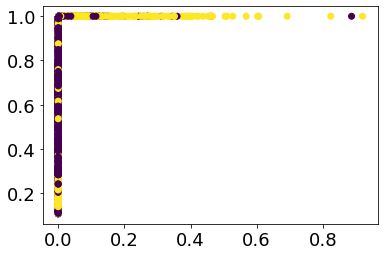

In [58]:
plt.scatter(rel_train['FIRE_SIZE'], rel_train['p_lightning'], c=rel_train['cause_lightning'])

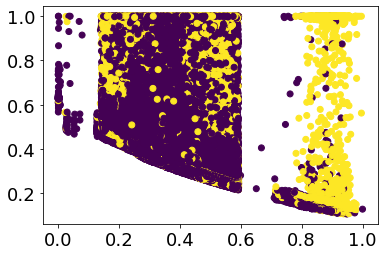

In [59]:
plt.scatter(rel_train['LATITUDE'], rel_train['p_lightning'], c=rel_train['cause_lightning'])

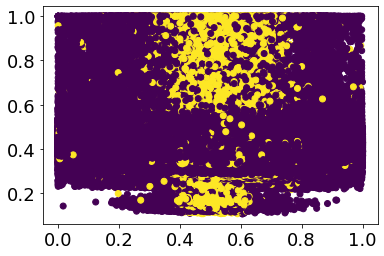

In [61]:
plt.scatter(rel_train['DISCOVERY_DOY'], rel_train['p_lightning'], c=rel_train['cause_lightning'])

Let's verify how well the algorithm does on the test data:

/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_39672/2060017643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_test['p_lightning'] = sigmoid(np.sum(rel_test[features].values * w_opt, axis=1))


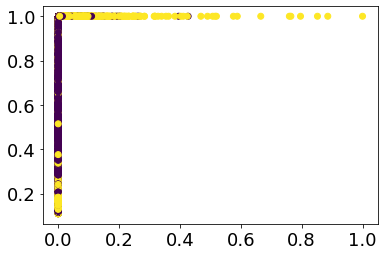

In [62]:
rel_test['p_lightning'] = sigmoid(np.sum(rel_test[features].values * w_opt, axis=1))

plt.scatter(rel_test['FIRE_SIZE'], rel_test['p_lightning'], c=rel_test['cause_lightning'])

Let's quantify exactly how well it's doing. We define the __false positive rate__ (number of non-lightning events incorrectly labelled as caused by lightning, divided by the total number of events) and the __false negative rate__ (lightning events labelled as non-lightning).  

We set the threshold for lightning events at $p > 0.5$.

In [69]:
false_positive = np.sum(~rel_test[rel_test['p_lightning'] > .5]['cause_lightning']) / len(rel_test) 
false_negative = np.sum(rel_test[rel_test['p_lightning'] < 0.5]['cause_lightning']) / len(rel_test) 

print("False positive rate: ", false_positive)
print("False negative rate: ", false_negative)

False positive rate:  0.0526023462917051
False negative rate:  0.1817332859451285


## 3. b) Full Classification Test

For the full classification of wildfire causes, we will move to a non-binary classification model. I'll try the Random Forest model.

### Features and Labels

Let's drop all rows where the cause is missing/undefined or miscellaneous and focus on causes the model would actually be able to predict so we don't throw off the model.

In [8]:
features_df = pd.read_sql('SELECT FIRE_YEAR, DISCOVERY_DOY,  STAT_CAUSE_CODE, STAT_CAUSE_DESCR, FIRE_SIZE, LATITUDE, LONGITUDE FROM fires',conn)
features = ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']
#features_df["DISCOVERY_TIME"] = pd.to_numeric(features_df['DISCOVERY_TIME'])

features_df.drop(features_df.index[features_df['STAT_CAUSE_DESCR'] == 'Missing/Undefined'], inplace=True)
features_df.drop(features_df.index[features_df['STAT_CAUSE_DESCR'] == 'Miscellaneous'], inplace=True)

for col_name in ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']:
    cmin = features_df[col_name].min()
    cmax = features_df[col_name].max()
    
    features_df[col_name] = (features_df[col_name] - cmin) / (cmax - cmin)
    
features_df 



,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE
1,0.521739,0.361644,1.0,Lightning,4.117507e-07,0.400646,0.514314
2,0.521739,0.413699,5.0,Debris Burning,1.646113e-07,0.401622,0.511398
3,0.521739,0.490411,1.0,Lightning,1.646113e-07,0.393509,0.518640
4,0.521739,0.490411,1.0,Lightning,1.646113e-07,0.393509,0.518466
5,0.521739,0.495890,1.0,Lightning,1.646113e-07,0.394962,0.516964
...,...,...,...,...,...,...,...
1880451,1.000000,0.427397,2.0,Equipment Use,1.647447e-06,0.395132,0.510270
1880452,1.000000,0.282192,5.0,Debris Burning,1.975632e-07,0.309592,0.529384
1880453,1.000000,0.512329,8.0,Children,1.975632e-07,0.311789,0.530020
1880457,1.000000,0.745205,7.0,Arson,1.647447e-06,0.432249,0.490842


In [9]:
# Use numpy to convert to arrays

# Labels are the values we want to predict
labels = np.array(features_df['STAT_CAUSE_CODE'])
labels_descr = np.array(features_df['STAT_CAUSE_DESCR'])

# Remove the labels from the features
features_df = features_df.drop(['STAT_CAUSE_DESCR','STAT_CAUSE_CODE'], axis = 1)

# Saving feature names for later use
feature_list = list(features_df.columns)

# Convert to numpy array
features_pd_df = features_df
features_df = np.array(features_df)

### Training and test datasets

In [19]:
# Skicit-learn splits data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features_df, labels, test_size = 0.4)

In [20]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (833962, 5)
Training Labels Shape: (833962,)
Testing Features Shape: (555975, 5)
Testing Labels Shape: (555975,)


### Training the forest

In [21]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model 
rf = RandomForestClassifier(n_estimators= 128)

# Train the model on training data
rf.fit(train_features, train_labels);

### Testing the predictions

In [22]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL ON TEST SET: ", metrics.accuracy_score(test_labels, predictions))


ACCURACY OF THE MODEL:  0.6218013399883088


In [23]:
print(test_labels[0:20])
print(predictions[0:20])


[7. 6. 5. 5. 6. 4. 1. 5. 1. 2. 5. 7. 1. 7. 2. 1. 4. 7. 1. 7.]
[7. 6. 5. 5. 6. 5. 1. 5. 1. 7. 5. 3. 1. 7. 1. 5. 4. 7. 5. 7.]


62% accuracy doesn't seem very good, but considering that some of the wildfire causes would look pretty similar from the data available (for example distinguishing between wildfires started by children vs. by arson), the model does not seem too bad. How accurate is the model on the training data? That could be an indicator of whether there is too much variability in the data to do much better with our model.

In [24]:
# Use the forest's predict method on the test data
predictionsTrain = rf.predict(train_features)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL ON TRAIN SET: ", metrics.accuracy_score(train_labels, predictionsTrain))

ACCURACY OF THE MODEL:  0.9998513121700989


The model is performing extremely well on the training data set and much worse (around 40% worse) on the testing data set. This suggests the model is overfitting quite a bit. 

### Tuning the hyperparameters to optimize the model

Note: I tried using GridSearchCV for a comprehensive and through search through the hyperparameter space but it was too computationally expensive on the large dataset. Instead, I will try using a randomized search to reduce computational time.

First, we look at our current hyperparameter values.

In [26]:
from pprint import pprint
# Look at parameters used by our current forest
print('Currently using parameters:\n')
pprint(rf.get_params())

Currently using parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 128,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Some parameters that could be optimized are number of trees in the forest (n_estimators), number of levels in the tree (max_depth), minimum number of samples to split a node, etc.

In [27]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in forest
n_estimators = [int(x) for x in np.linspace(100,1000,10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

Now that we have a long list of hyperparameter combinations to try, we use a random grid to search for the best combination. We will start with trying just 20 different combinations and using all available cores so the process does not take prohibitively long. 

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(train_features, train_labels)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
rf_random.best_params_

In [ ]:
def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

### Identifying and visualizing important features

In [77]:
feature_imp = pd.Series(rf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

LONGITUDE        0.330139
LATITUDE         0.257024
DISCOVERY_DOY    0.209110
FIRE_YEAR        0.104742
FIRE_SIZE        0.098984
dtype: float64

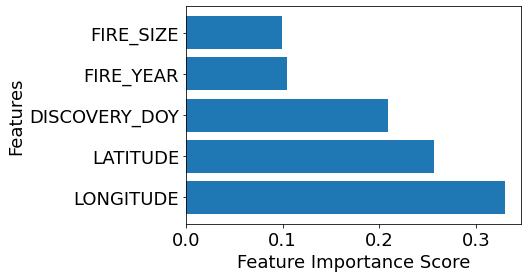

In [86]:
# Creating a bar plot
plt.barh(feature_imp.index, feature_imp)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

If we remove the least important features in the model: fire size and fire year, can we improve the accuracy of the model? 

### Removing less important features from the model

In [90]:
# Remove fire size and fire year from the features
features_min_df = features_pd_df.drop(['FIRE_SIZE','FIRE_YEAR'], axis = 1)

# Saving feature names for later use
feature_list_min = list(features_min_df.columns)

# Convert to numpy array
features_min_df = np.array(features_min_df)

In [91]:
# Split the data into training and testing sets
train_features_min, test_features_min, train_labels_min, test_labels_min = train_test_split(features_min_df, labels, test_size = 0.3)


In [92]:
# Instantiate model 
rf_min = RandomForestClassifier(n_estimators= 200)

# Train the model on training data
rf_min.fit(train_features_min, train_labels_min);

In [93]:
# Use the forest's predict method on the test data
predictions_min = rf_min.predict(test_features_min)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(test_labels_min, predictions_min))


ACCURACY OF THE MODEL:  0.5823296928884221


The model has gotten worse actually so we can conclude that the fire size and fire year features are important. Are there any predictive features in the data we are not including at the moment? How can we do better? 